In [ ]:
%pylab nbagg

In [2]:
from scipy.misc import imread
import pyopencl, os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1" 
import pyopencl.array as gpuarray
sRGB = imread("grid-8M_v2.jpg", flatten=False)
print(sRGB.shape, sRGB.dtype)
import numpy
#import silx.opencl
#print(pyFAI.opencl.ocl)
#pyopencl.create_some_context(interactive=True)

(2464, 3280, 3) uint8


In [3]:
src= """

static float dec_sRGB(uchar value)
{
    float res, a=0.055f, gamma=2.4f,slope=12.92f; 
    if (value<=10)
        res = (float)value/255.0/slope;
    else
        res = pow(((float)value/255.0f + a)/(1.0f+a), gamma);
    return res;
}

static uchar comp_sRGB(float value)
{
    float a=0.055f, gamma=2.4f,slope=12.92f, c=0.0031308f; 
    float res;
    if (value<=c)
        res = value*slope;
    else
        res = (1.0f+a) * powr(value, 1.0f/gamma) - a;
    if (res<0.0f)
        res = 0.0f;
    else if (res>1.0f)
        res = 255.0f;
    else
        res = 255.0f*res + 0.5f;
    
    return (uchar) res;
}

static float comp_L(float value)
{ //https://fr.wikipedia.org/wiki/CIE_L*a*b*

    float epsilon = 216.0f/24389.0f,
          kappa = 24389.0f/27.0f,
          res;
    if (value>epsilon)
        res = pow(value, 1.0f/3.0f);
    else
        res = (kappa * value + 16.0f)/ 116.0f;
    return res;
}

static float dec_L(float value)
{
    float d = 6.0f/29.0f, res;
    if (value>d)
        res = pown(value, 3);
    else
        res = (value - 4.0f/29.0f) * 3.0f * d * d;
    return res;
}

static float3 XYZ2Lab(float3 XYZ)
{
    float3 Lab, 
           D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz = XYZ/D65,
           fxyz = (float3)(comp_L(xyz.x), comp_L(xyz.y), comp_L(xyz.z));
    Lab = (float3)(116.0f * fxyz.y - 16.0f,
                   500*(fxyz.x - fxyz.y),
                   200*(fxyz.y - fxyz.z));
    return Lab;
}

static float3 Lab2XYZ(float3 Lab)
{
    float3 D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz;
    float l;
           
    l = (Lab.x + 16.0f)/116.0f;
    xyz = (float3)(dec_L(l + Lab.y/500.0f),
                   dec_L(l),
                   dec_L(l - Lab.z/200.0f));
    return xyz * D65;
}

static float3 RGB2XYZ(float3 RGB)
{
    //const float matrix[9] = {0.4124f, 0.3576f, 0.1805f, 0.2126f, 0.7152f, 0.0722f, 0.0193f, 0.1192f, 0.9505f};
    const float3 to_X = (float3)(0.4124f, 0.3576f, 0.1805f);
    const float3 to_Y = (float3)(0.2126f, 0.7152f, 0.0722f);
    const float3 to_Z = (float3)(0.0193f, 0.1192f, 0.9505f);
    return (float3)(dot(RGB, to_X), dot(RGB, to_Y), dot(RGB, to_Z));
}

static float3 XYZ2RGB(float3 XYZ)
{
    //const float matrix[9] = {3.2410f, -1.5374f, -0.4986f, -0.9692f,  1.8760f,  0.0416f, 0.0556f, -0.2040f,  1.0570f};
    const float3 to_R = (float3)( 3.2410f,-1.5374f,-0.4986f),
                 to_G = (float3)(-0.9692f, 1.8760f, 0.0416f),
                 to_B = (float3)( 0.0556f,-0.2040f,1.0570f);
    return (float3)(dot(XYZ, to_R), dot(XYZ, to_G), dot(XYZ, to_B));
}


kernel void decompress_sRGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = dec_sRGB(sRGB[i]);
        RGB[i+1] = dec_sRGB(sRGB[i+1]);
        RGB[i+2] = dec_sRGB(sRGB[i+2]);
    }
}

kernel void compress_sRGB(global float *RGB, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = comp_sRGB(sRGB[i]);
        RGB[i+1] = comp_sRGB(sRGB[i+1]);
        RGB[i+2] = comp_sRGB(sRGB[i+2]);
    }
}

kernel void sRGB_to_Lab(global uchar *sRGB, global float *Lab, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        XYZ = RGB2XYZ(RGB);
        LAB = XYZ2Lab(XYZ);
        Lab[i] = LAB.x;
        Lab[i+1] = LAB.y;
        Lab[i+2] = LAB.z;
    }
}

kernel void Lab_to_sRGB(global float *Lab, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB = (float3)(Lab[i], Lab[i+1], Lab[i+2]);
        XYZ = Lab2XYZ(LAB);
        RGB = XYZ2RGB(XYZ);
        sRGB[i] = comp_sRGB(RGB.x);
        sRGB[i+1] = comp_sRGB(RGB.y);
        sRGB[i+2] = comp_sRGB(RGB.z);
    }
}


kernel void convert_color(global float *RGB, global float *XYZ, int width, int height, global float *matrix)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        XYZ[3*i+0] = RGB[3*i]*matrix[0] + RGB[3*i+1]*matrix[1] + RGB[3*i+2]*matrix[2];
        XYZ[3*i+1] = RGB[3*i]*matrix[3] + RGB[3*i+1]*matrix[4] + RGB[3*i+2]*matrix[5];
        XYZ[3*i+2] = RGB[3*i]*matrix[6] + RGB[3*i+1]*matrix[7] + RGB[3*i+2]*matrix[8];
    }
}

kernel void sRGB_to_RGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB3;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB3 = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        RGB[i] = RGB3.x;
        RGB[i+1] = RGB3.y;
        RGB[i+2] = RGB3.z;
    }
}

// load a float3 from a given prosition:
static float3 load3(global float* image,
                    int index)
{
    float3 res = (float3)(image[3*index], image[3*index+1], image[3*index+2]);
    return res;
}

//Perform a bilinear interpolation of image with 3 channels
static float3 bilinear3(float2 target, 
                        global float* image,
                        int2 size,
                        float3 fill,
                        int mode) //mode = 1 bilinear or 0 for nearest
{
    int tx_prev = (int) target.x,
        tx_next = tx_prev + 1,
        ty_prev = (int) target.y,
        ty_next = ty_prev + 1;

    float3 interp = fill;

    if (0.0f <= target.x && target.x < (size.x - 1) && 0.0f <= target.y && target.y < (size.y - 1) )
    {
        if (mode == 1) 
        {   //bilinear interpolation: read 4 neighbours
            float3 image_p = load3(image, ty_prev*size.x + tx_prev),
                   image_x = load3(image, ty_prev*size.x + tx_next),
                   image_y = load3(image, ty_next*size.x + tx_prev),
                   image_n = load3(image, ty_next*size.x + tx_next);

            if (tx_next >= size.x) 
            {
                image_x = image_p;
                image_n = image_y;
            }
            if (ty_next >= size.y) {
                image_y = image_p;
                image_n = image_x;
            }

            //bilinear interpolation
            float3 interp1 = ((float) (tx_next - target.x)) * image_p + ((float) (target.x - tx_prev)) * image_x,
                   interp2 = ((float) (tx_next - target.x)) * image_y + ((float) (target.x - tx_prev)) * image_n;

            interp = ((float) (ty_next - target.y)) * interp1 + ((float) (target.y - ty_prev)) * interp2;

        }
        else 
        { //no interpolation TODO: round index !
                interp = load3(image, (int)(target.y + 0.5) * size.x + (int)(target.x + 0.5));
        }
    }
    
    //to be coherent with scipy.ndimage.interpolation.affine_transform
    if (target.x >= (size.x - 1)) 
        interp = fill;
    if (target.y >= (size.y - 1)) 
            interp = fill;
    return interp;
}

kernel void rotate_image(global float *inp, global float *out, int width, int height, float angle)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float cx = width/2.0f, cy = height/2.0f, xout, yout;
        xout = (float) get_global_id(0);
        yout = (float) get_global_id(1);
        
        float2 target = (float2)(cos(angle)*(xout - cx) + sin(angle)*(yout - cy) + cx,
                                -sin(angle)*(xout - cx) + cos(angle)*(yout - cy) + cy);
        int i = get_global_id(0) + width * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width, height),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        //K1 = arg[8]*1e-9
        //K2 = arg[9]*1e-15
        //K3 = arg[10]*1e-23
        //return c + (u - c)*
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        float2 target = (float2)(center_dis_x + xcor*correction,
                                 center_dis_y + ycor*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}
kernel void unwrap_rot_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3, float angle)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction, xcorr, ycorr;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        xcorr = cos(angle) * xcor - sin(angle) * ycor;
        ycorr = sin(angle) * xcor + cos(angle) * ycor;
        float2 target = (float2)(center_dis_x + xcorr*correction,
                                 center_dis_y + ycorr*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

"""

ctx = pyopencl.create_some_context(answers=["0"])#, "0"])
print(ctx)
queue = pyopencl.CommandQueue(ctx)
prg = pyopencl.Program(ctx, src).build()

srgb_d  = gpuarray.empty(queue, sRGB.shape, sRGB.dtype)
srgb2_d  = gpuarray.empty(queue, sRGB.shape, sRGB.dtype)
rgb_d  = gpuarray.empty(queue, sRGB.shape, "float32")
xyz_d  = gpuarray.empty(queue, sRGB.shape, "float32")
lab_d  = gpuarray.empty(queue, sRGB.shape, "float32")
lab2_d  = gpuarray.empty(queue, sRGB.shape, "float32")
srgb_d.set(sRGB)
#print(srgb_d)
e1=prg.decompress_sRGB(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
                      srgb_d.data, rgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]))
e1.wait()
#RGB2XYZ_d  = gpuarray.empty(queue, 9, "float32")
#XYZ2RGB_d  = gpuarray.empty(queue, 9, "float32")
#RGB2XYZ_d.set(numpy.array([0.4124, 0.3576, 0.1805, 0.2126, 0.7152, 0.0722, 0.0193, 0.1192, 0.9505], "float32"))
#XYZ2RGB_d.set(numpy.array([3.2410, -1.5374, -0.4986, -0.9692,  1.8760,  0.0416,0.0556, -0.2040,  1.0570], "float32"))
#e2=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 rgb_d.data, xyz_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), RGB2XYZ_d.data)
#e2.wait()

#e3=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 xyz_d.data, rgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), XYZ2RGB_d.data)
#e3.wait()
#e4=prg.compress_sRGB(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                     rgb_d.data, srgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]))
#e4.wait()
#srgb_d
print(abs(srgb_d.get()-sRGB.astype(int)).max())
print(rgb_d.get()[0,0])

<pyopencl.Context at 0x55e0400da4d0 on <pyopencl.Device 'GeForce GTX 750 Ti' on 'NVIDIA CUDA' at 0x55e040086160>>
0
[ 0.19461787  0.14412849  0.23455061]


In [4]:
shape = sRGB.shape
Lab_d  = gpuarray.empty(queue, shape, "float32")
Lab2_d  = gpuarray.empty(queue, shape, "float32")
e1=prg.sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb_d.data, Lab_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
e1.wait()
# print(Lab_d)


In [5]:
e2=prg.rotate_image(queue, (shape[1], shape[0]), None, 
                    Lab_d.data, Lab2_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]), numpy.float32(numpy.radians(5)))

e2.wait()


In [6]:
e4=prg.Lab_to_sRGB(queue, (shape[1], shape[0]), None, 
                     Lab2_d.data, srgb2_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
e4.wait()
#print(srgb_d)
abs(srgb2_d.get()-sRGB.astype(int)).max()

165

<IPython.core.display.Javascript object>


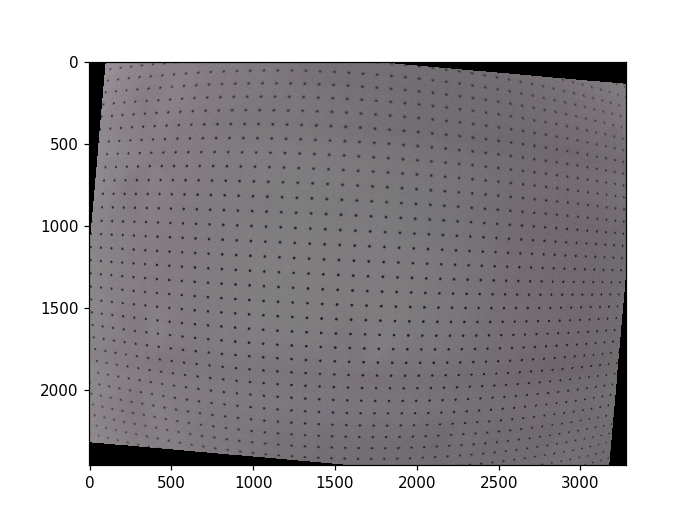

In [7]:
f, ax = subplots()
ax.imshow(srgb2_d.get())


<IPython.core.display.Javascript object>


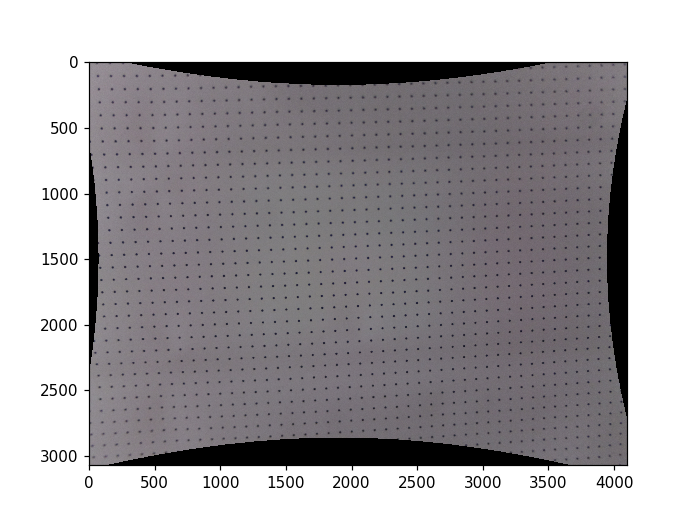

In [11]:
center_x =  1.57404213e+03,   #1.49115944e+03   #shape[1]/2.0 #1.49115944e+03   
center_y = 1.21426268e+03 #1.05505293e+03   #shape[0]/2.0 #1.05505293e+03   
rot = numpy.arctan2(3.98061926e+00, 9.17420696e+01)
k1 = -5.06963753e+01 *1e-9  #-5.43929745e-8   
k2 =  3.09760765e+00 *1e-15 #3.85088852e-15  
k3 = -1.08441890e+01 *1e-23 #-1.47189658e-22
big_shape = (3072, 4096, 3)
Lab_big_d  = gpuarray.empty(queue, big_shape, "float32")
sRGB_big_d  = gpuarray.empty(queue, big_shape, "uint8")
e2=prg.unwrap_image(queue, (big_shape[1], big_shape[0]), None, 
                    Lab_d.data, Lab_big_d.data, 
                    numpy.int32(shape[1]), numpy.int32(shape[0]), 
                    numpy.int32(big_shape[1]), numpy.int32(big_shape[0]), 
                    numpy.float32(center_x), numpy.float32(center_y),
                    numpy.float32(1900), numpy.float32(1500),
                    numpy.float32(k1),numpy.float32(k2),numpy.float32(k3))

e2.wait()
e4=prg.Lab_to_sRGB(queue, (big_shape[1], big_shape[0]), None, 
                     Lab_big_d.data, sRGB_big_d.data, numpy.int32(big_shape[1]), numpy.int32(big_shape[0]))
e4.wait()
f, ax = subplots()
ax.imshow(sRGB_big_d.get())


<IPython.core.display.Javascript object>


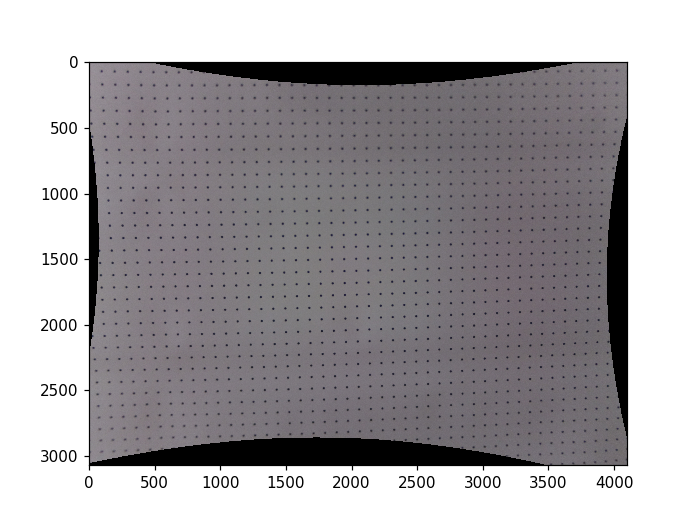

In [14]:
rot = numpy.arctan2(-1.53494493e+00,   7.65411342e+01)#3.98061926e+00, 9.17420696e+01)

e2=prg.unwrap_rot_image(queue, (big_shape[1], big_shape[0]), None, 
                    Lab_d.data, Lab_big_d.data, 
                    numpy.int32(shape[1]), numpy.int32(shape[0]), 
                    numpy.int32(big_shape[1]), numpy.int32(big_shape[0]), 
                    numpy.float32(center_x), numpy.float32(center_y),
                    numpy.float32(1900), numpy.float32(1500),
                    numpy.float32(k1),numpy.float32(k2),numpy.float32(k3), numpy.float32(rot))

e2.wait()
e4=prg.Lab_to_sRGB(queue, (big_shape[1], big_shape[0]), None, 
                     Lab_big_d.data, sRGB_big_d.data, numpy.int32(big_shape[1]), numpy.int32(big_shape[0]))
e4.wait()
f, ax = subplots()
ax.imshow(sRGB_big_d.get())


In [ ]:
def xyz2rgb(xyz):
    def from_linear(v):
        def clamp(v):
            if v < 0.0:
                return 0.0
            elif v > 1.0:
                return 1.0
            else:
                return v
        if v <= 0.0031308:
            return int(clamp(v * 12.92) * 255.0 + 0.5)
        else:
            return int(clamp(1.055 * v ** (1.0 / 2.4) - 0.055) * 255.0 + 0.5)
    rgb_linear = [ 3.2410 * xyz[0] - 1.5374 * xyz[1] - 0.4986 * xyz[2],
                  -0.9692 * xyz[0] + 1.8760 * xyz[1] + 0.0416 * xyz[2],
                   0.0556 * xyz[0] - 0.2040 * xyz[1] + 1.0570 * xyz[2]]
    return [from_linear(c) for c in rgb_linear]

def rgb2xyz(rgb):
    def to_linear(c):
        v = c / 255.0
        if v <= 0.04045:
            return v / 12.92
        else:
            return ((v + 0.055) / 1.055) ** 2.4
    v = [to_linear(c) for c in rgb]
    return [ 0.4124 * v[0] + 0.3576 * v[1] + 0.1805 * v[2],
             0.2126 * v[0] + 0.7152 * v[1] + 0.0722 * v[2],
             0.0193 * v[0] + 0.1192 * v[1] + 0.9505 * v[2]]

def xyz2lab(xyz):
    def f(t):
        d = 6.0 / 29.0
        if t > (d ** 3):
            return t ** (1.0 / 3.0)
        else:
            return (1.0 / 3.0) * ((1 / d) ** 2) * t + (4.0 / 29.0)
    xyzn =  [0.9504,  1.0000, 1.0888] # D65
    return [116.0 * f(xyz[1] / xyzn[1]) - 16.0,
            500.0 * (f(xyz[0] / xyzn[0]) - f(xyz[1] / xyzn[1])),
            200.0 * (f(xyz[1] / xyzn[1]) - f(xyz[2] / xyzn[2]))]

def lab2xyz(lab):
    d = 6.0 / 29.0
    def f(fn, nn):
        if fn > d:
            return nn * (fn ** 3)
        else:
            return (fn - 16.0 / 116.0) * 3 * (d ** 2) * nn
    xyzn =  [0.9504,  1.0000, 1.0888] # D65
    fy = (lab[0] + 16.0) / 116.0
    fx = fy + lab[1] / 500.0
    fz = fy - lab[2] / 200.0
    return [f(fx, xyzn[0]), f(fy, xyzn[1]), f(fz, xyzn[2])]

def rgb2lab(rgb):
    return xyz2lab(rgb2xyz(rgb))

def lab2rgb(lab):
    return xyz2rgb(lab2xyz(lab))

In [ ]:
rgb2xyz([129, 112, 140])-numpy.array([ 0.19541594 , 0.18098067 ,                          0.27396226])


In [ ]:
0.04045*255


In [ ]:
def rgb2lab_v2 ( inputColor ) :
   num = 0
   RGB = [0, 0, 0]

   for value in inputColor :
       value = float(value) / 255

       if value > 0.04045 :
           value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
       else :
           value = value / 12.92

       RGB[num] = value 
       num = num + 1
   print("RGB", RGB)
   XYZ = [0, 0, 0,]

   X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
   Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
   Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
   XYZ[ 0 ] = round( X, 4 )
   XYZ[ 1 ] = round( Y, 4 )
   XYZ[ 2 ] = round( Z, 4 )
   print("XYZ", XYZ)

   XYZ[ 0 ] = float( XYZ[ 0 ] ) / 0.95047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
   XYZ[ 1 ] = float( XYZ[ 1 ] ) / 1.000          # ref_Y = 100.000
   XYZ[ 2 ] = float( XYZ[ 2 ] ) / 1.08883        # ref_Z = 108.883
   
   num = 0
   for value in XYZ :

       if value > 0.008856 :
           value = value ** ( 0.3333333333333333 )
       else :
           value = ( 7.787 * value ) + ( 16 / 116 )

       XYZ[num] = value
       num = num + 1

   Lab = [0, 0, 0]

   L = ( 116 * XYZ[ 1 ] ) - 16
   a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
   b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

   Lab [ 0 ] = round( L, 4 )
   Lab [ 1 ] = round( a, 4 )
   Lab [ 2 ] = round( b, 4 )
   print("Lab", Lab)
   return Lab

In [ ]:
print(rgb2lab(sRGB[0,0,:]))
print(rgb2lab_v2(sRGB[0,0,:]))
print(Lab_d.get()[0,0,:])
print(xyz_d.get()[0,0,:])

<IPython.core.display.Javascript object>


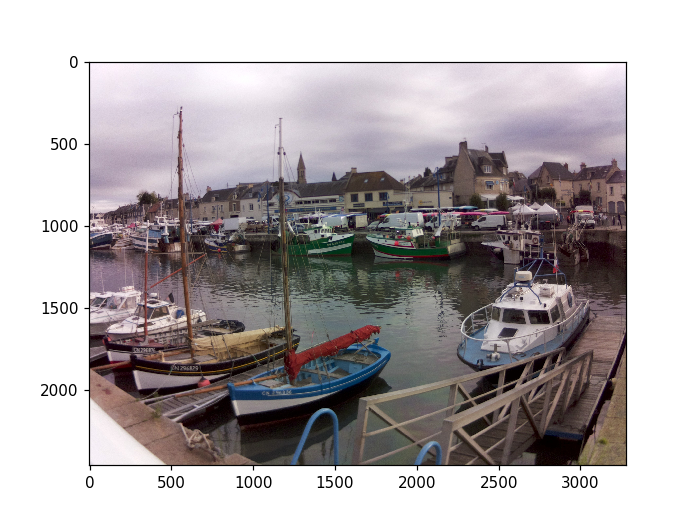

In [15]:
path="/scratch/jerome/TimeLapses/2017-08-04-port-en-bessin/2017-08-04-19h45m04s.jpg"
from PIL import Image
raw = numpy.asarray(Image.open(path))
f, ax =  subplots()
ax.imshow(raw)

In [16]:
import json
from gi.repository import GExiv2
exif = GExiv2.Metadata(path)
header = json.loads(exif.get_comment())
def get_rot(filename):
    exif = GExiv2.Metadata(filename)
    header = json.loads(exif.get_comment())
    return numpy.arctan2(-header["gx"],-header["gz"])
get_rot(path)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:2: PyGIWarning: GExiv2 was imported without specifying a version first. Use gi.require_version('GExiv2', '0.10') before import to ensure that the right version gets loaded.
  from ipykernel import kernelapp as app


0.076958228077500385

<IPython.core.display.Javascript object>


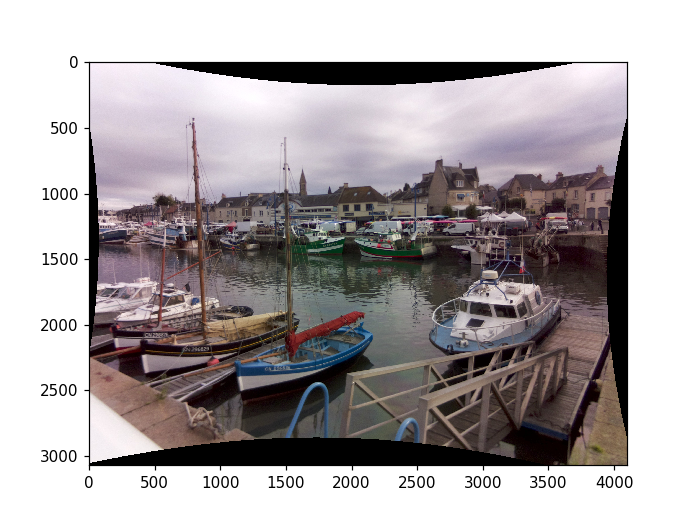

In [21]:
def correct(path):
    raw = numpy.asarray(Image.open(path))
    srgb_d.set(raw)
    e1=prg.sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb_d.data, Lab_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
    angle = get_rot(path)
    e2=prg.unwrap_rot_image(queue, (big_shape[1], big_shape[0]), None, 
                    Lab_d.data, Lab_big_d.data, 
                    numpy.int32(shape[1]), numpy.int32(shape[0]), 
                    numpy.int32(big_shape[1]), numpy.int32(big_shape[0]), 
                    numpy.float32(center_x), numpy.float32(center_y),
                    numpy.float32(1900), numpy.float32(1500),
                    numpy.float32(k1),numpy.float32(k2),numpy.float32(k3), numpy.float32(rot))

    e4=prg.Lab_to_sRGB(queue, (big_shape[1], big_shape[0]), None, 
                         Lab_big_d.data, sRGB_big_d.data, numpy.int32(big_shape[1]), numpy.int32(big_shape[0]))
    return sRGB_big_d.get()

f, ax = subplots()
ax.imshow(correct(path))
#ax.imshow(correct("/scratch/jerome/TimeLapses/2017-08-13-mt_st_michel/2017-08-13-20h47m06s.jpg"))


<IPython.core.display.Javascript object>


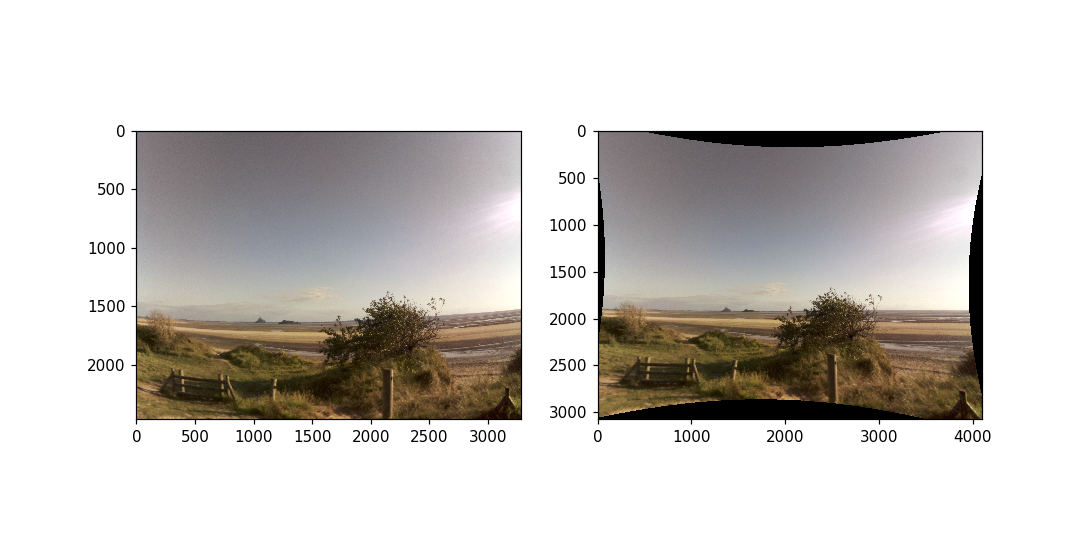

In [22]:
f, ax = subplots(1,2, figsize=(10,5))
f = "/scratch/jerome/TimeLapses/2017-08-13-mt_st_michel/2017-08-13-19h22m23s.jpg"
raw = numpy.asarray(Image.open(f))
ax[0].imshow(raw)
ax[1].imshow(correct(f))